# 04 - Applied ML

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import networkx as nx
%matplotlib inline

# Question 1
## 1. A naive analysis

In [2]:
data = pd.read_csv('lalonde.csv')
data.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [3]:
def plot_feature(feature_name, data):
    r_min = data[feature_name].min()
    r_max = data[feature_name].max()
    
    data_treated = data[data["treat"] == 1]
    data_untreated = data[data["treat"] == 0]
    
    plt.figure(figsize=(16,6))
    plt.suptitle(feature_name, fontsize=20)
    ax = plt.subplot(1,2,1)
    plt.hist(data_treated[feature_name], normed=True, bins=40, range=(r_min, r_max))
    plt.title("Treated people", fontsize=14)
    plt.subplot(1,2,2, sharey=ax)
    plt.title("Untreated people", fontsize=14)
    plt.hist(data_untreated[feature_name], normed=True, bins=40, range=(r_min, r_max))
    plt.show()

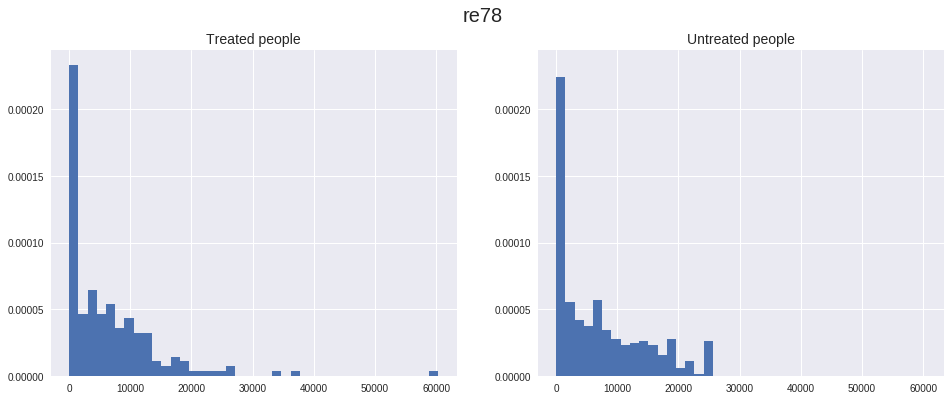

In [4]:
plot_feature('re78', data)

## 2. A closer look at the data

In [5]:
data_features = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']
data_features.remove('re78')
data_features

['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']

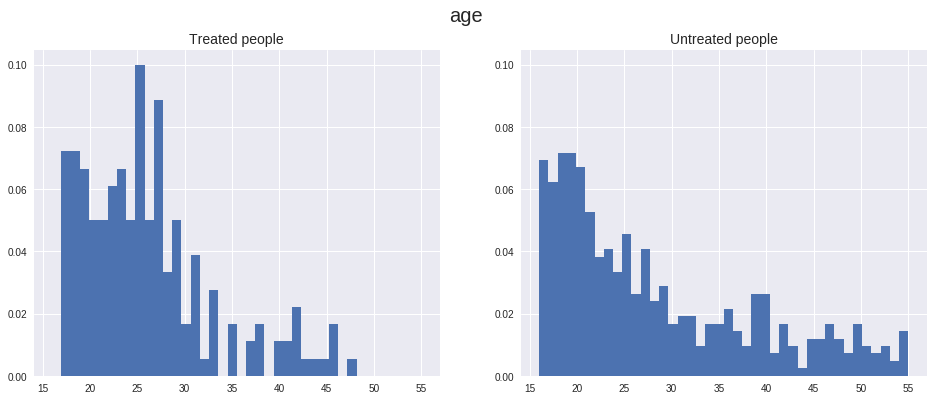

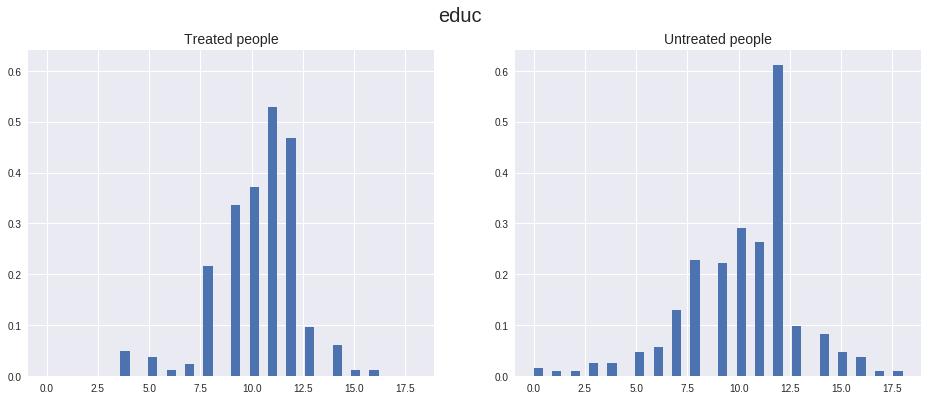

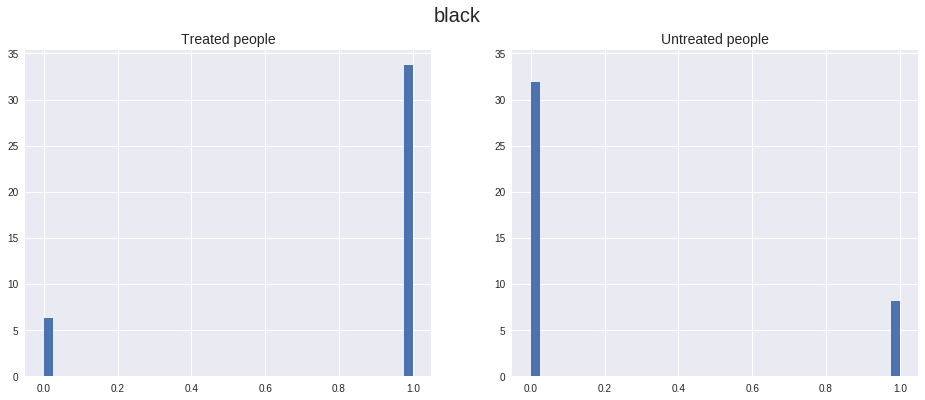

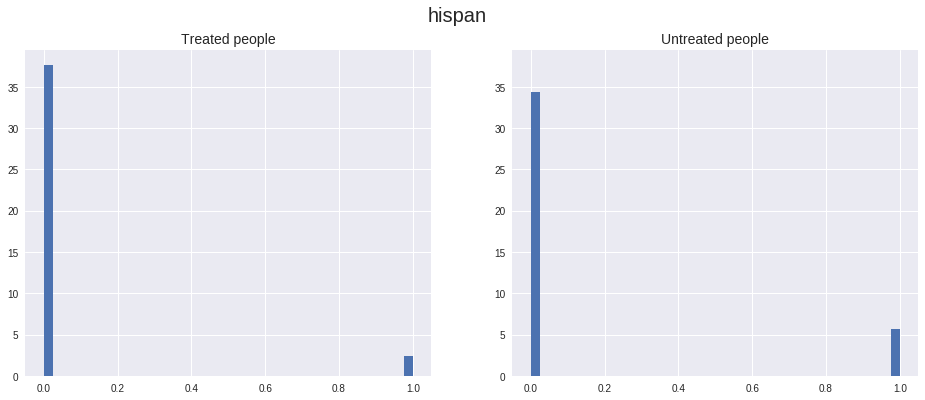

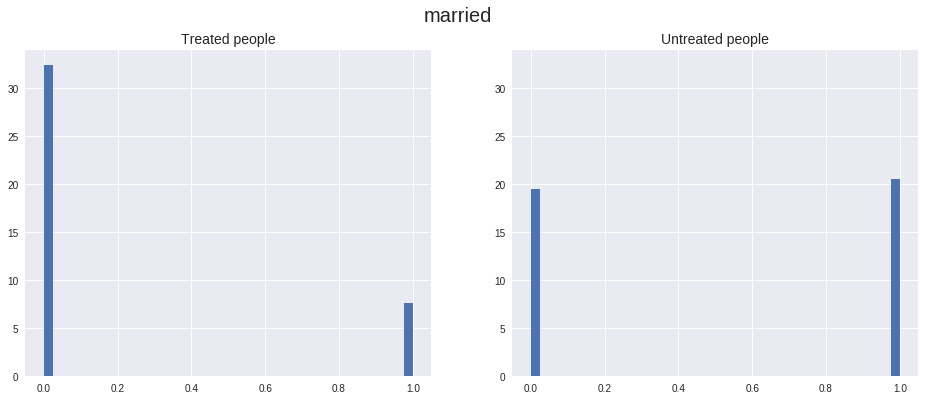

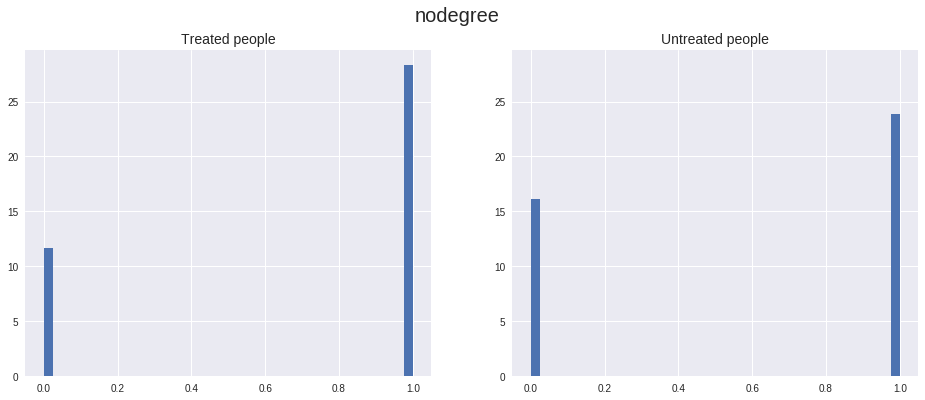

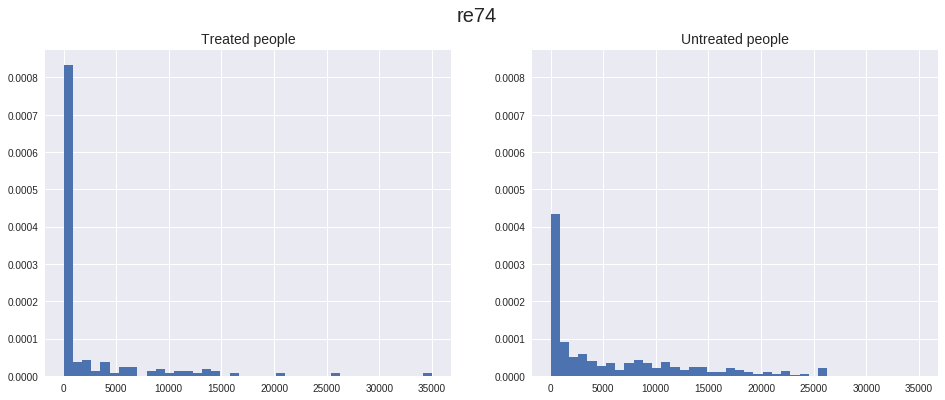

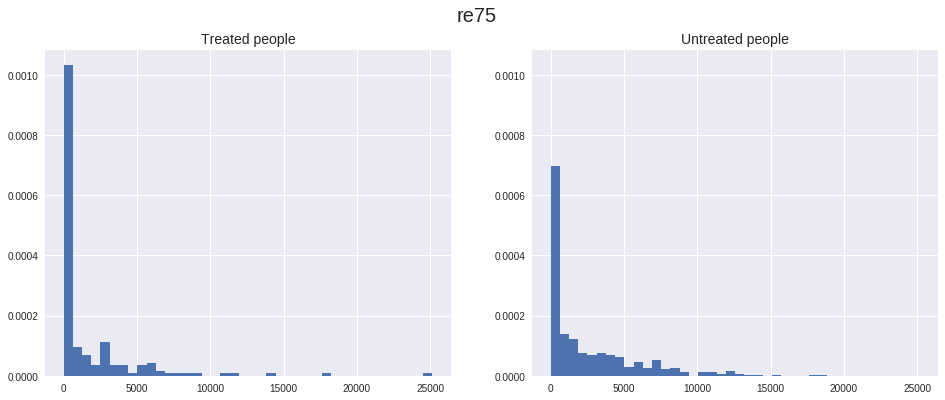

In [6]:
for col in ["age", "educ", "black", "hispan", "married", "nodegree", "re74", "re75"]:
    plot_feature(col, data)

## 3. A propsensity score model

In [7]:
# The features vector
X = data[data_features]
# The label vector
y = data['treat']

logistic = LogisticRegression()
logistic.fit(X, y)
pred_prob = logistic.predict_proba(X)
pred_prob

array([[ 0.55664958,  0.44335042],
       [ 0.85534047,  0.14465953],
       [ 0.27764537,  0.72235463],
       ..., 
       [ 0.87687096,  0.12312904],
       [ 0.44954003,  0.55045997],
       [ 0.84497047,  0.15502953]])

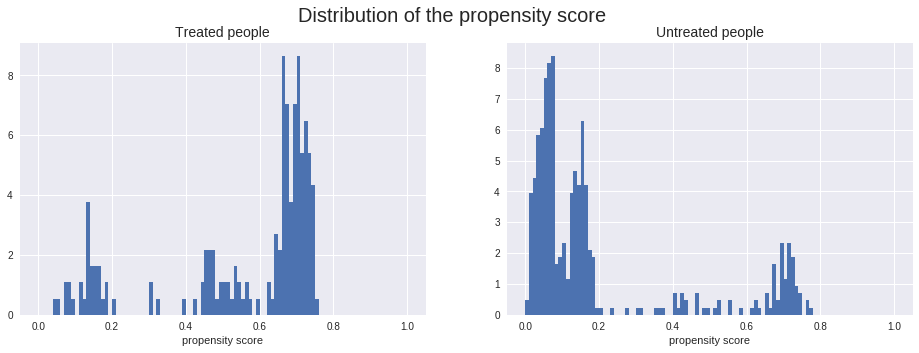

0.561869387932
0.196656023697


In [8]:
treated_idx = np.where(data['treat'] == 1)[0]
untreated_idx = np.where(data['treat'] == 0)[0]

pred_prob_treated = pred_prob[treated_idx, 1]
pred_prob_untreated = pred_prob[untreated_idx, 1]

plt.figure(figsize=(16,5))
plt.suptitle("Distribution of the propensity score", fontsize=20)
plt.subplot(1,2,1)
plt.hist(pred_prob_treated, bins=100, range=(0, 1), normed=True)
plt.xlabel('propensity score')
plt.title("Treated people", fontsize=14)

plt.subplot(1,2,2)
plt.hist(pred_prob_untreated, bins=100, range=(0, 1), normed=True)
plt.title("Untreated people", fontsize=14)
plt.xlabel('propensity score')
plt.show()

print(np.mean(pred_prob_treated))
print(np.mean(pred_prob_untreated))

## 4. Balancing the dataset via matching

In [9]:
g = nx.graph.Graph()
    
for index in data.index:
    g.add_node(index)
    
for t_index in treated_idx:
    for unt_index in untreated_idx:
        dist = np.abs(pred_prob[t_index, 1] - pred_prob[unt_index, 1])
        g.add_edge(t_index, unt_index, weight=1 - dist)
        
matching = nx.max_weight_matching(g)

In [10]:
matched_idx = list(matching.keys())
matched_data = data.iloc[matched_idx,:]
matched_treated = matched_data[matched_data["treat"] == 1]
matched_untreated = matched_data[matched_data["treat"] == 0]

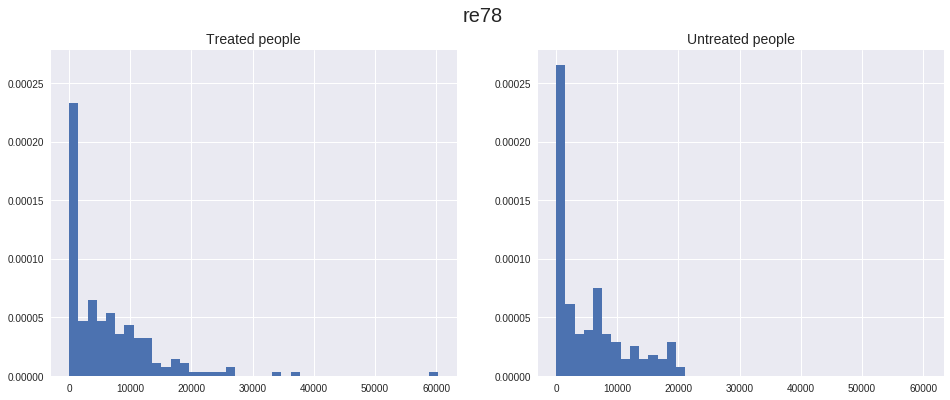

In [11]:
plot_feature("re78", matched_data)

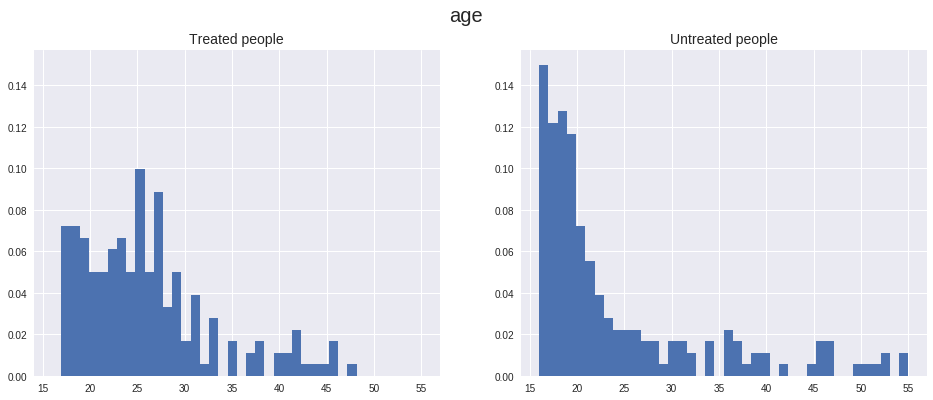

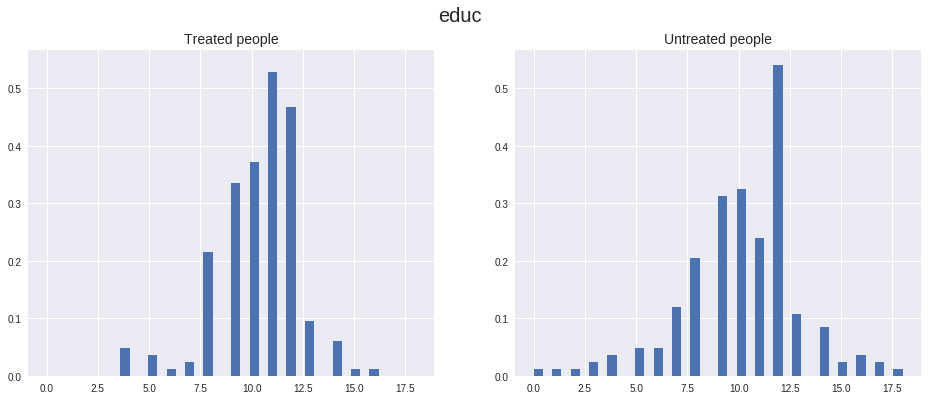

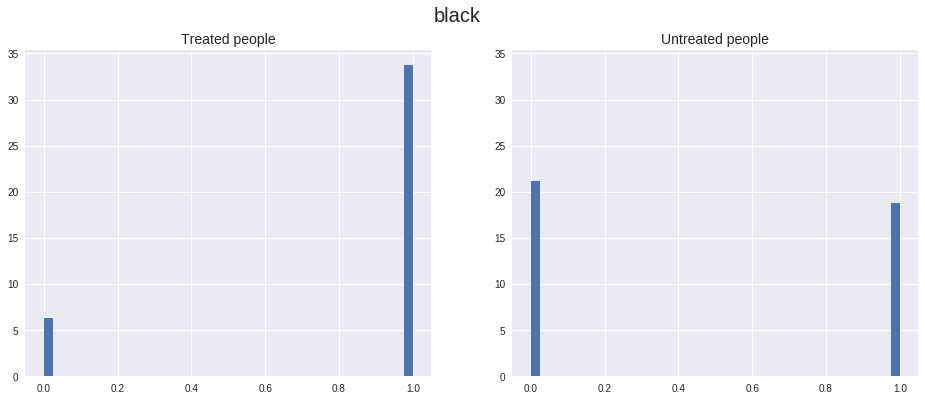

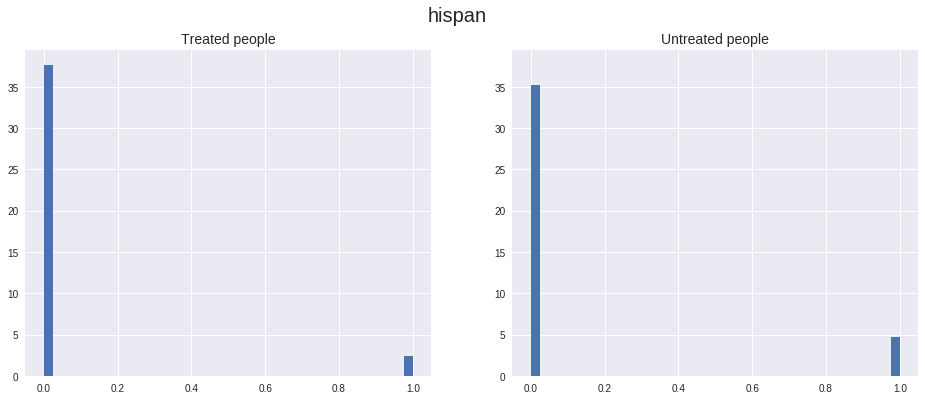

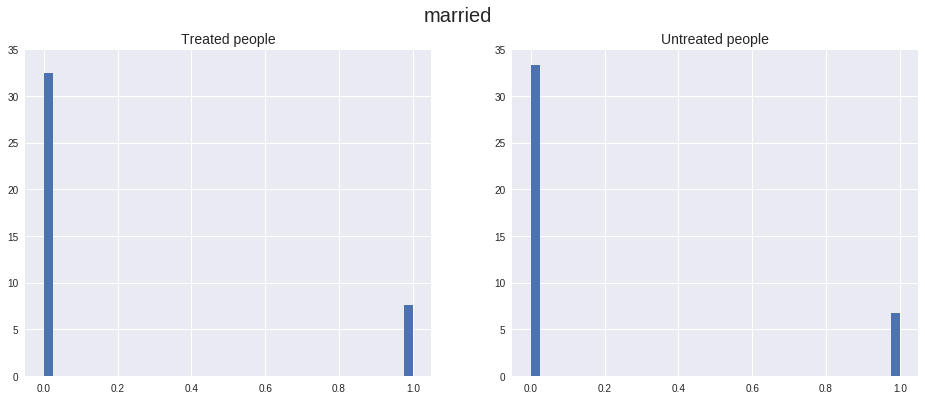

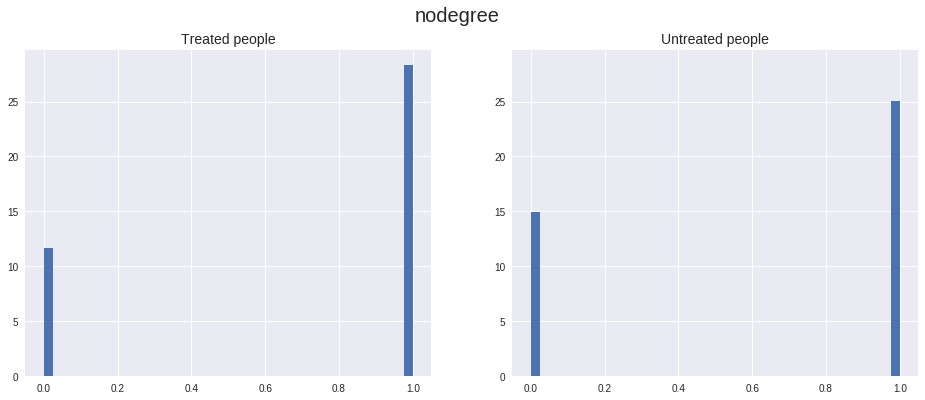

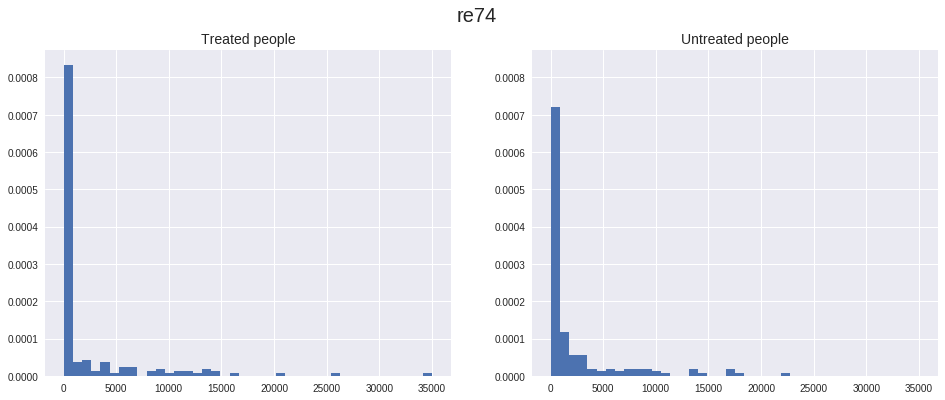

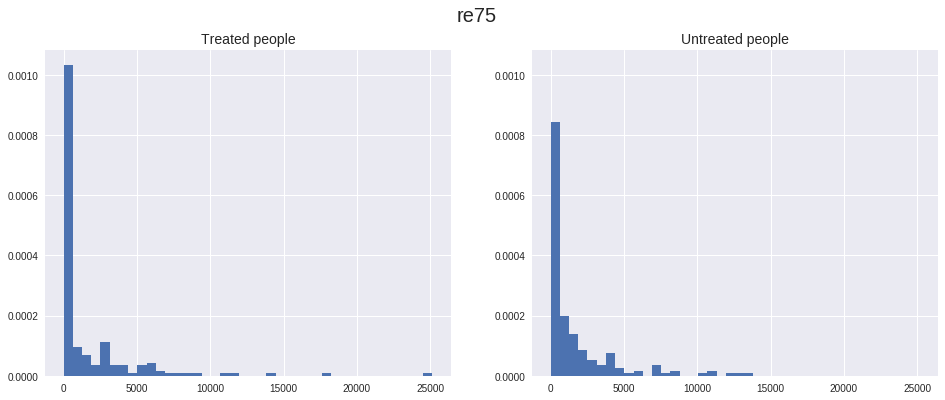

In [12]:
for col in ["age", "educ", "black", "hispan", "married", "nodegree", "re74", "re75"]:
    plot_feature(col, matched_data)

The data has a similar distribution, the treated group can now be compared with the control group.

## 5. Balancing the groups further

We notice that the black feature does not balance well enough making it diffucult to draw valid conclusion on the treatement. We will explicitly match only if this feature matches.

In [13]:
matched_data

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
595,PSID411,0,18,10,1,0,0,1,0.0000,0.0000,5306.51600
24,NSW25,1,18,10,1,0,0,1,0.0000,0.0000,11163.17000
585,PSID401,0,17,10,1,0,0,1,0.0000,0.0000,1053.61900
28,NSW29,1,17,10,1,0,0,1,0.0000,0.0000,16218.04000
582,PSID398,0,17,8,1,0,0,1,0.0000,0.0000,4520.36600
42,NSW43,1,17,8,1,0,0,1,0.0000,0.0000,8061.48500
576,PSID392,0,17,10,1,0,0,1,0.0000,0.0000,0.00000
30,NSW31,1,17,10,1,0,0,1,0.0000,0.0000,0.00000
573,PSID389,0,18,11,1,0,0,1,0.0000,0.0000,7146.28600
52,NSW53,1,18,11,1,0,0,1,0.0000,0.0000,0.00000


## 6. A less naive analysis

# Question 2: Applied ML

In [14]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
newsgroups_train = fetch_20newsgroups(subset='train')

In [16]:
def split_data(x, y, ratio):
    '''
        split the dataset based on the split ratio. If ratio is 0.8,
        you will have 80% of your data set dedicated to training
        and the rest dedicated to testing
    '''
    random_uniform_vector = np.random.rand(x.shape[0])
    spliter = random_uniform_vector < ratio
    return (x[spliter == True], y[spliter == True]), (x[spliter == False], y[spliter == False])

In [18]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(newsgroups_train["data"])

(train_X, train_Y), (other_X, other_Y)  = split_data(X, newsgroups_train["target"], 0.8)
(validation_X, validation_Y), (test_X, test_Y) = split_data(other_X, other_Y, 0.5)

In [41]:
best_accuracy = 0.
best_n_est = 1
best_max_dep = 1

for n_est in range(5, 30, 5):
    for max_dep in range(20, 100, 10):
        print("doing : (%s, %s)" % (n_est, max_dep), end="\r")
        classifier = RandomForestClassifier(n_estimators=50, max_depth=100)
        classifier.fit(train_X, train_Y)
        
        prediction = classifier.predict(validation_X)
        accuracy = (len(prediction) - np.count_nonzero(prediction - validation_Y)) / len(prediction)
        
        if accuracy > best_accuracy:
            print("best accuracy : %s" % accuracy)
            best_accuracy = accuracy
            best_n_est = n_est
            best_max_dep = max_dep

best accuracy : 0.822141560798548
best accuracy : 0.8321234119782214
